In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# # YOLOv3 모델 불러오기
# net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg.txt')
# layer_names = net.getLayerNames()


### 문제: YOLOv3는 멀리있는 사람인식못함. 
####  해결을 위해
#### - 이번에는 YOLOv4를 사용해 보았다.
#### - 다중스케일을 사용한다(멀리있는이미지를 크게 보기위해)
#### - 이미지 전처기 histogram equlization활용

In [27]:
# 더 정확한 이미지 도출위해서 YOLOv4모델 불러오기
net = cv2.dnn.readNetFromDarknet("yolov4.cfg.txt", "yolov4.weights")
layer_names = net.getLayerNames()

In [28]:
# YOLO 네트워크 출력 레이어 이름 얻기
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

In [29]:
# 이미지 불러오기
img = cv2.imread('workers.jpg')
height, width, channels = img.shape

#### 해결을 위해 이미지 전처리중 하나로 이미지 크기를 더 크게 바꾼다 - 마지막 인력까지 잡았음 해결!!!!

In [31]:
# YOLO 모델의 입력 크기를 608x608로 바꾼다
blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), (0, 0, 0), True, crop=False)

In [32]:
# 네트워크에 입력
net.setInput(blob)
outs = net.forward(output_layers)

In [33]:
# 결과에서 객체 검출
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5  # 신뢰도 임계값
nms_threshold = 0.4  # 비최대 억제 임계값

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
        if confidence > conf_threshold:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [34]:
# 비최대 억제 (NMS) 수행
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

In [35]:
# 객체를 이미지에 표시 (컨투어 사용)
for i in indices.flatten():
    x, y, w, h = boxes[i]
    roi = img[y:y+h, x:x+w]  # 감지된 영역 (Region of Interest)

    # 그레이스케일로 변환
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # 이진화 처리
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # 컨투어 찾기
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 컨투어 그리기
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # 면적이 100 이상인 컨투어만
            cv2.drawContours(img, [contour + (x, y)], -1, (0, 255, 0), 2)


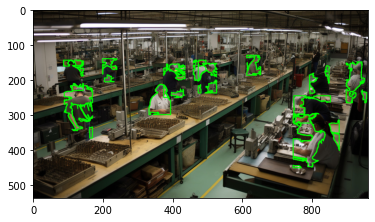

In [37]:
# plt.imshow  
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

### 회고:  YOLO라는 다른 모델을 알게 되어서 적용해보았는데, 조금서 나은 성능이어서 도움이 되었다. 다양한 다른모델들도 확인해보면 좋을것 같다.
### YOLO(You Only Look Once) 모델
#### - 실시간 객체 탐지(Object Detection)를 위해 개발된 딥러닝 모델
#### - 이미지나 비디오에서 특정 객체를 탐지하고 해당 객체의 경계 상자(Bounding Box)와 라벨을 출력하는 데 사용됨

#### - 이미지를 한 번만 처리하여 객체를 탐지하여 속도가 빠름
#### - 단일 신경망 구조를 사용하여 이미지를 격자로 나눈 뒤, 각 격자에서 객체 탐지와 클래스 예측을 동시에 수행:
#### - 컨텍스트 정보를 활용해 이미지 전체를 한 번에 분석하므로, 배경과 객체를 잘 구분함
#### - 단, 작은 객체를 탐지하거나 겹친 객체를 구분하는 데는 약간의 한계가 있을 수 있음
